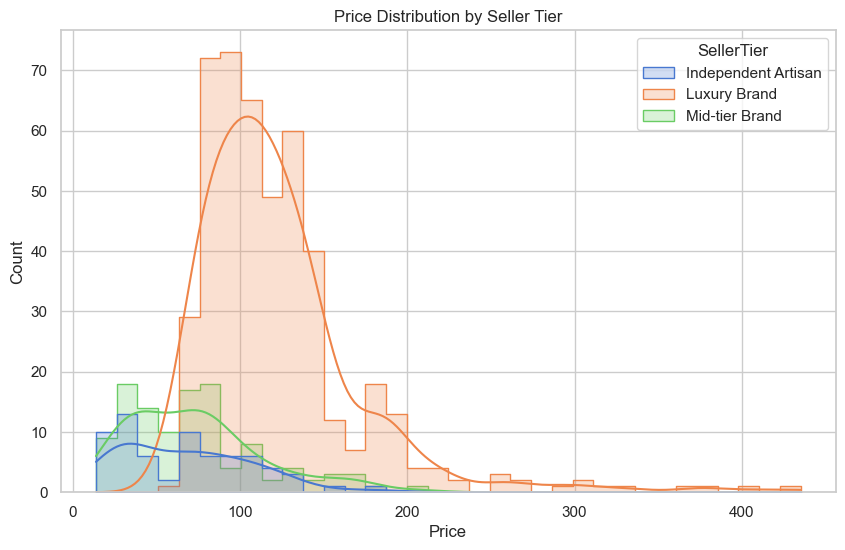

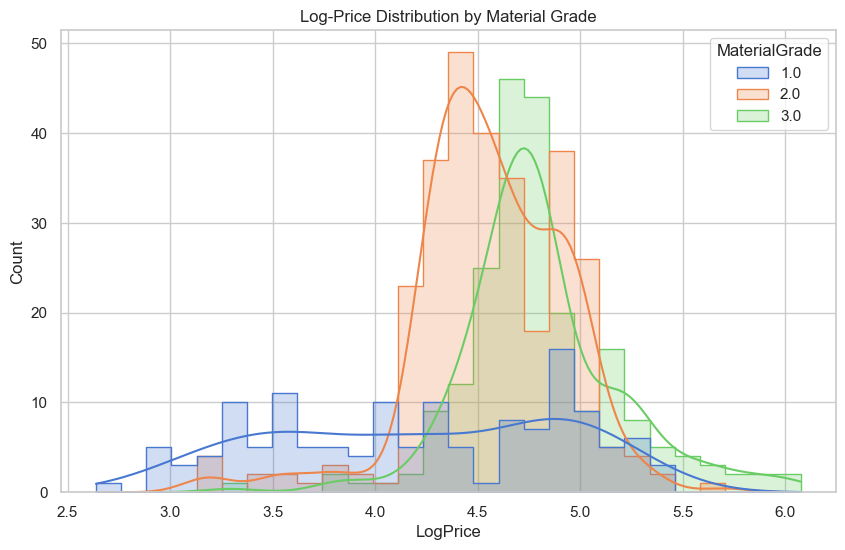

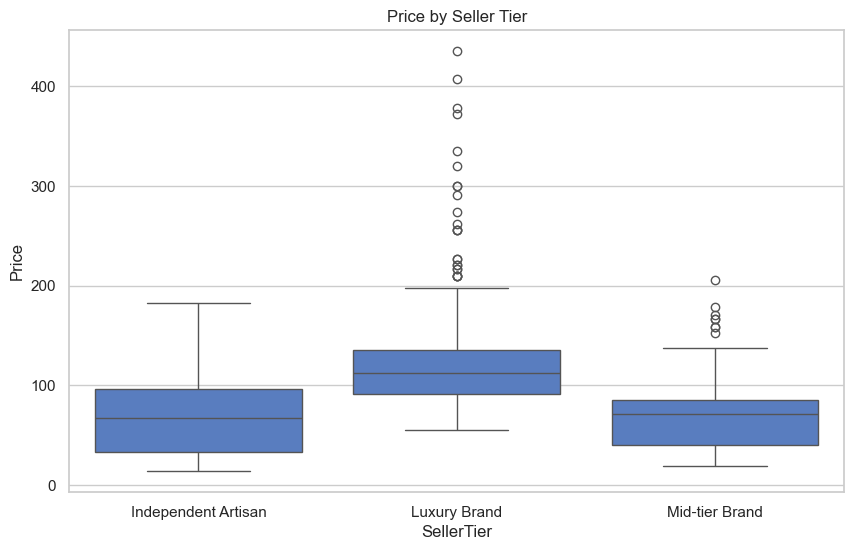

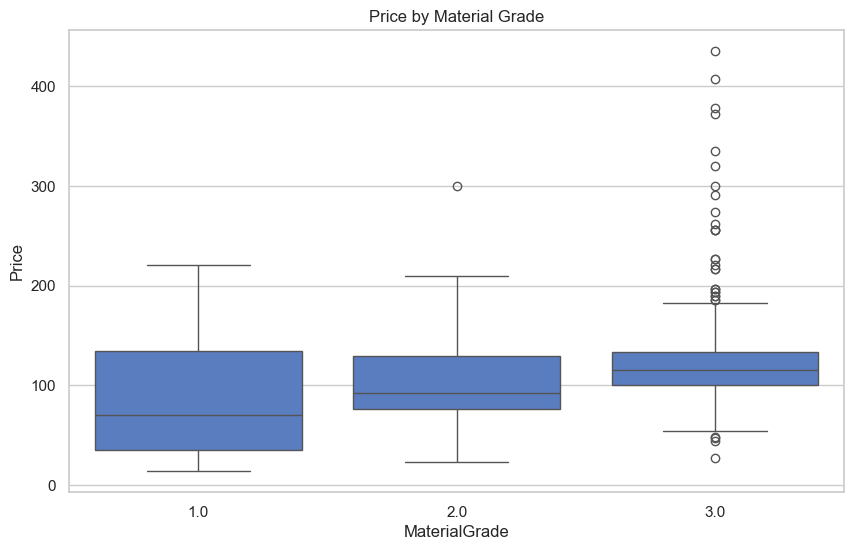

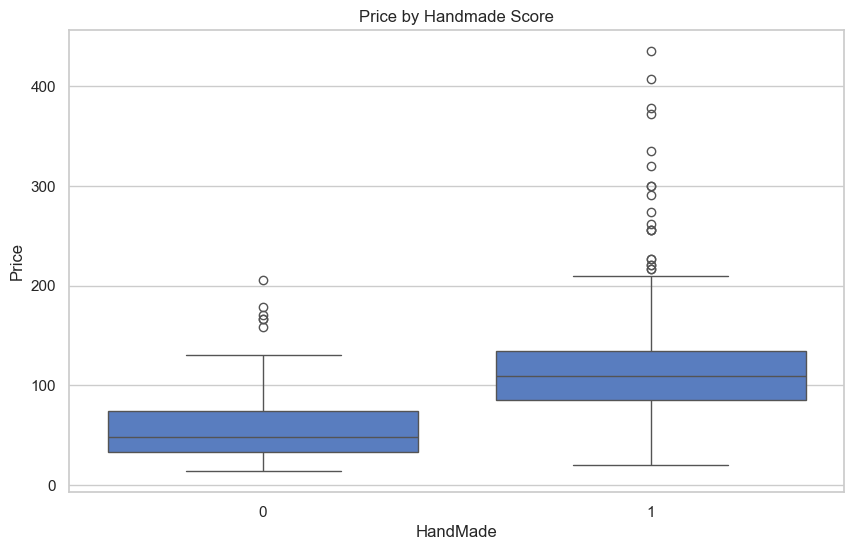

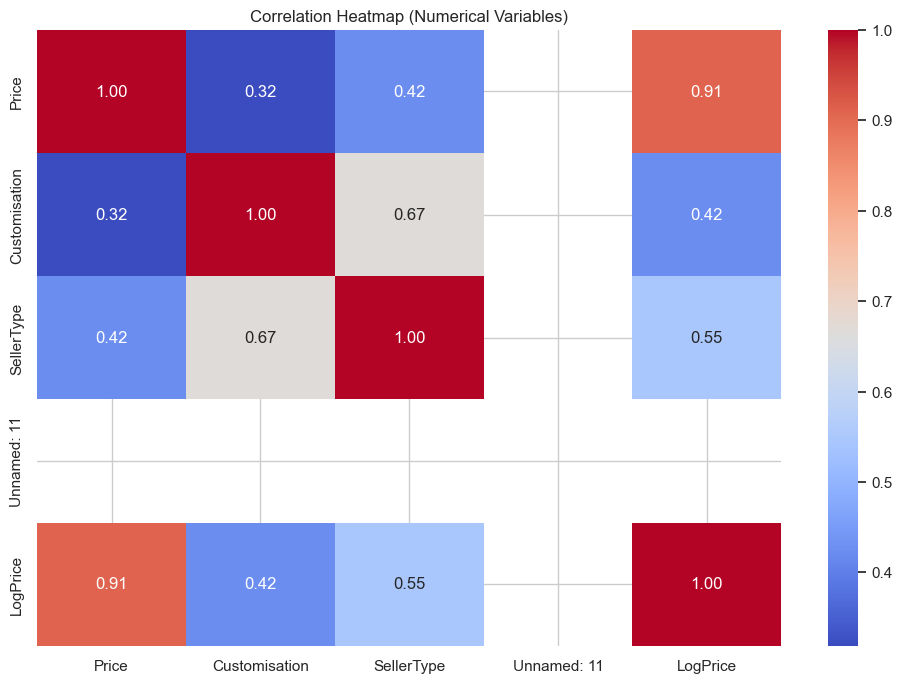

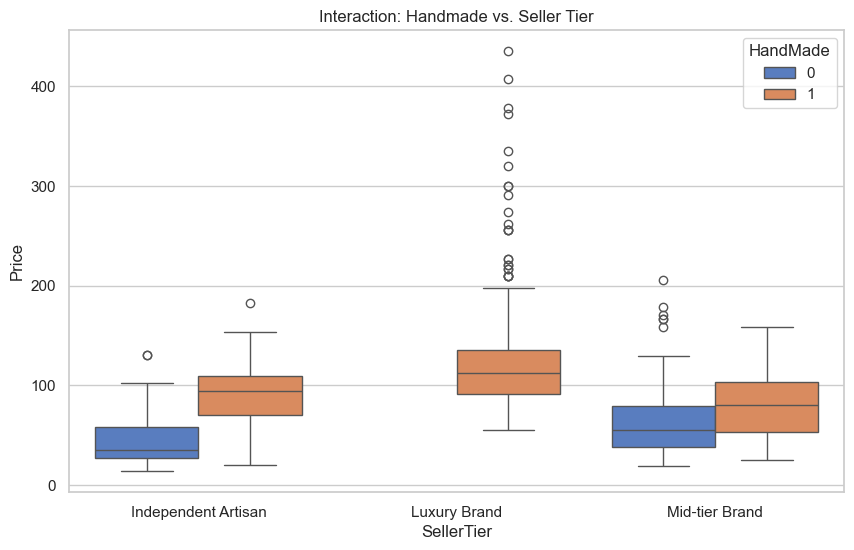

All plots saved to: C:\Users\User\OneDrive\Desktop\Dissertation\Jupiter\Graph


C:\Users\User\AppData\Local\Temp\ipykernel_28528\3330541902.py:194: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sub.pivot_table(index="MaterialGrade",


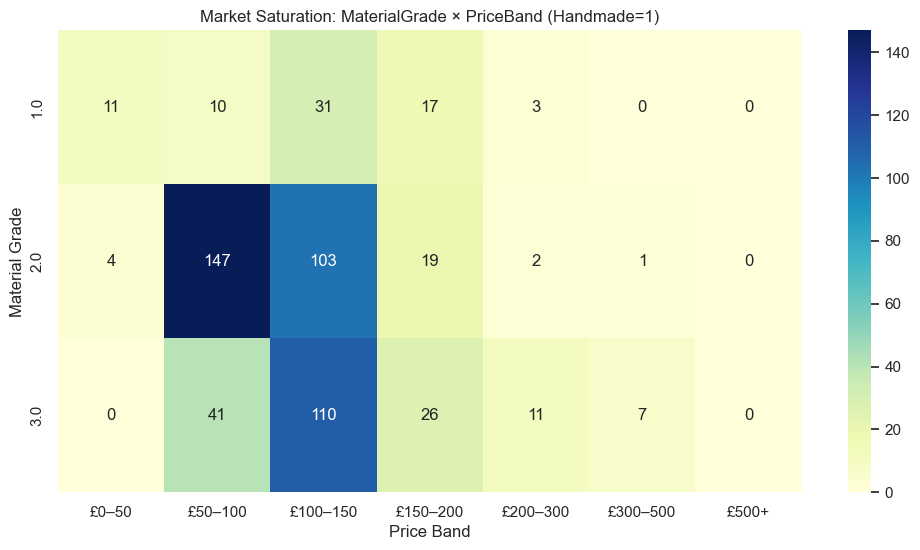

C:\Users\User\AppData\Local\Temp\ipykernel_28528\3330541902.py:194: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  sub.pivot_table(index="MaterialGrade",


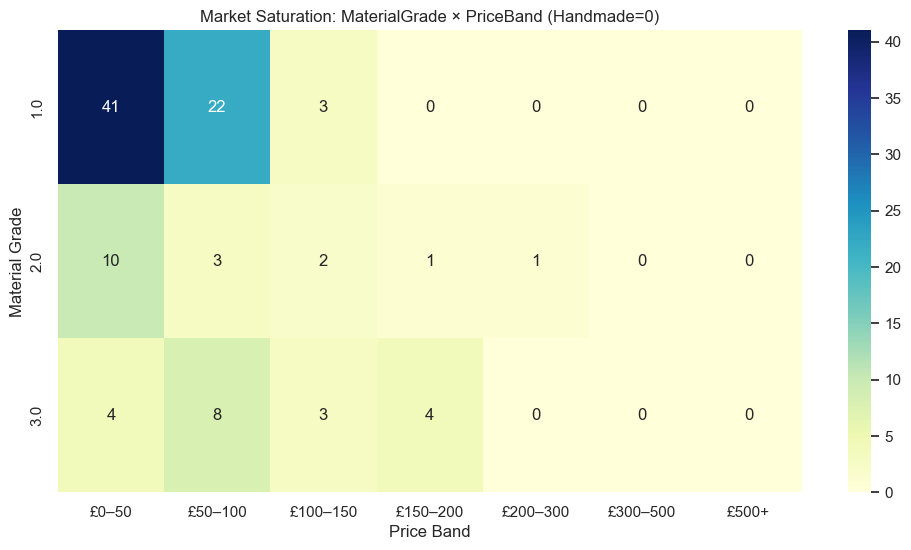

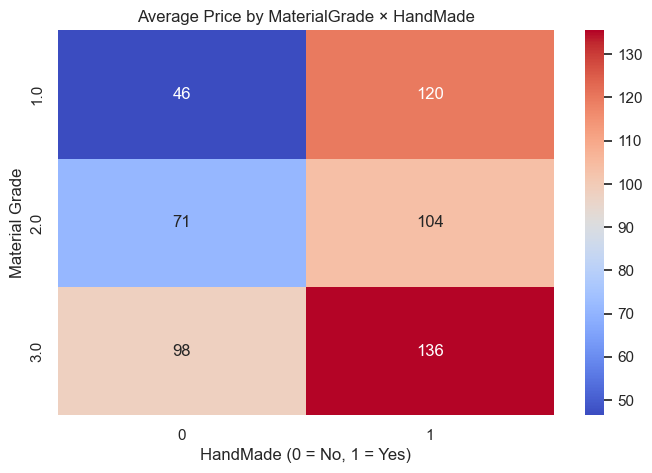

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


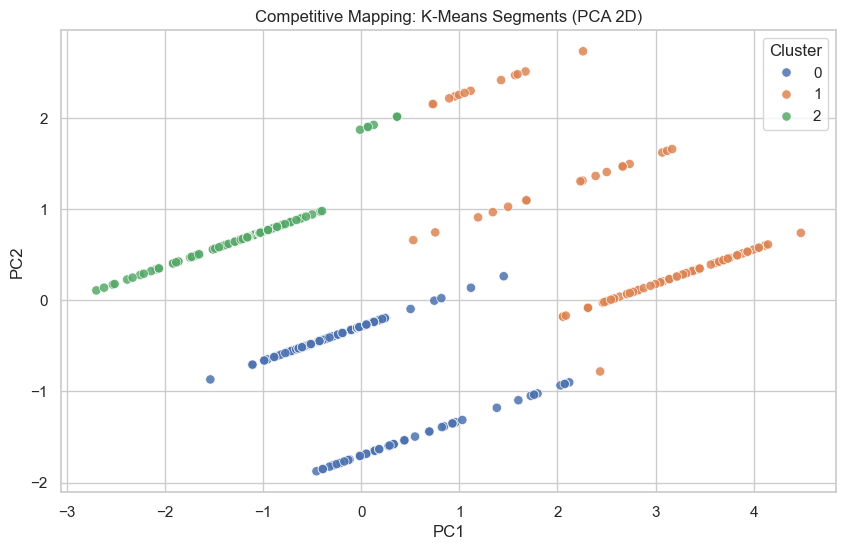


Cluster profiles (feature means):
          LogPrice  MaterialGrade  HandMade
Cluster                                   
0            4.61           1.80      1.00
1            3.82           1.43      0.01
2            4.84           3.00      0.97
Descriptive statistics saved to C:\Users\User\OneDrive\Desktop\Dissertation\Jupiter\Result\descriptive_statistics.xlsx


In [25]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\Dissertation\Custom Watchstraps main.csv")

# --- Basic cleaning ---
df.columns = df.columns.str.strip()

# Price numeric & positive
df["Price"] = pd.to_numeric(df.get("Price"), errors="coerce")
df = df[df["Price"].notna() & (df["Price"] > 0)]

# LogPrice safe
df["LogPrice"] = np.log(df["Price"].clip(lower=1e-9))

# ----- Clean/derive SellerTier from SellerType (Excel-safe) -----
# SellerType may be float (1.0, 2.0, 3.0) or strings ("1","2","3"). Make it clean integers 1/2/3 first.
if "SellerType" in df.columns: 
    st = pd.to_numeric(df["SellerType"], errors="coerce")
    # Some Excel sheets may have things like 1.0; round then cast to int
    st = st.round().astype("Int64")  # pandas nullable int
    df["SellerType"] = st
else:
    df["SellerType"] = pd.Series(dtype="Int64")

tier_map = {1: "Independent Artisan", 2: "Mid-tier Brand", 3: "Luxury Brand"}
if "SellerTier" not in df.columns:
    df["SellerTier"] = df["SellerType"].map(tier_map)
df["SellerTier"] = df["SellerTier"].fillna("Unknown").astype("category")

# ----- Categorical tidy (from Excel) -----
for col in ["MaterialGrade", "Platform"]:
    if col in df.columns:
        # Coerce MaterialGrade to numeric if it came in as text like "2"
        if col == "MaterialGrade":
            df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].astype("category")

# HandMade can be "Yes/No", 1/0, "1"/"0", True/False — normalise to 0/1 category
if "HandMade" in df.columns:
    handmade_map = {"Yes": 1, "No": 0, "yes": 1, "no": 0, True: 1, False: 0}
    hm = df["HandMade"].replace(handmade_map)
    hm = pd.to_numeric(hm, errors="coerce").fillna(0).round().astype(int)
    df["HandMade"] = hm.astype("category")

# --- Output directory ---
output_dir = r"C:\Users\User\OneDrive\Desktop\Dissertation\Jupiter\Graph"
os.makedirs(output_dir, exist_ok=True)

# --- Plot styling ---
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

# --- Save helper ---
def save_and_show(fig, filename):
    path = os.path.join(output_dir, filename)
    fig.savefig(path, format="jpeg", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# --- Safe hist helper to avoid KDE + legend errors ---
def histplot_safe(data, x, hue=None, kde=True, title="", filename="hist.jpeg", element="step"):
    cols = [x] + ([hue] if hue else [])
    plot_df = data[cols].dropna()

    if plot_df.empty:
        print(f"[INFO] Skipping '{title}' – no data after dropna.")
        return

    # If a hue is provided, check group sizes; KDE needs >=2 per group
    if hue:
        group_sizes = plot_df.groupby(hue, observed=False).size()
        if (group_sizes < 2).any():
            print(f"[INFO] Not enough data to fit KDE for '{title}'. Disabling KDE.")
            kde = False

        # If after dropping NAs the hue column has no valid levels, turn off hue
        if plot_df[hue].nunique(dropna=True) == 0:
            print(f"[INFO] No valid hue levels for '{title}'. Plotting without hue.")
            hue = None

    fig, ax = plt.subplots()
    sns.histplot(data=plot_df, x=x, hue=hue, kde=kde, element=element, ax=ax)
    ax.set_title(title)
    save_and_show(fig, filename)



# ---- Histogram: Price by Seller Tier (safe KDE) ----
histplot_safe(
    data=df,
    x="Price",
    hue="SellerTier",
    kde=True,
    title="Price Distribution by Seller Tier",
    filename="price_by_seller_tier.jpeg",
    element="step"
)

# ---- Histogram: LogPrice by Material Grade (safe KDE) ----
if "MaterialGrade" in df.columns:
    histplot_safe(
        data=df,
        x="LogPrice",
        hue="MaterialGrade",
        kde=True,
        title="Log-Price Distribution by Material Grade",
        filename="logprice_by_material_grade.jpeg",
        element="step"
    )

# ---- Boxplot: Price by Seller Tier ----
plot_df = df[["SellerTier", "Price"]].dropna()
if not plot_df.empty:
    fig, ax = plt.subplots()
    sns.boxplot(data=plot_df, x="SellerTier", y="Price", ax=ax)
    ax.set_title("Price by Seller Tier")
    save_and_show(fig, "boxplot_price_by_seller_tier.jpeg")

# ---- Boxplot: Price by Material Grade ----
if "MaterialGrade" in df.columns:
    plot_df = df[["MaterialGrade", "Price"]].dropna()
    if not plot_df.empty:
        fig, ax = plt.subplots()
        sns.boxplot(data=plot_df, x="MaterialGrade", y="Price", ax=ax)
        ax.set_title("Price by Material Grade")
        save_and_show(fig, "boxplot_price_by_material_grade.jpeg")

# ---- Boxplot: Price by Handmade ----
if "HandMade" in df.columns:
    plot_df = df[["HandMade", "Price"]].dropna()
    if not plot_df.empty:
        fig, ax = plt.subplots()
        sns.boxplot(data=plot_df, x="HandMade", y="Price", ax=ax)
        ax.set_title("Price by Handmade Score")
        save_and_show(fig, "boxplot_price_by_handmade.jpeg")

# ---- Boxplot: Price by Platform ----
if "Platform" in df.columns:
    plot_df = df[["Platform", "Price"]].dropna()
    if not plot_df.empty:
        fig, ax = plt.subplots()
        sns.boxplot(data=plot_df, x="Platform", y="Price", ax=ax)
        ax.set_title("Price by Platform")
        save_and_show(fig, "boxplot_price_by_platform.jpeg")

# ---- Correlation Heatmap (numerical only) ----
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
    ax.set_title("Correlation Heatmap (Numerical Variables)")
    save_and_show(fig, "correlation_heatmap.jpeg")

# ---- Interaction: Handmade x Seller Tier ----
if "HandMade" in df.columns:
    plot_df = df[["SellerTier", "HandMade", "Price"]].dropna()
    if not plot_df.empty and plot_df["SellerTier"].nunique() > 0:
        fig, ax = plt.subplots()
        sns.boxplot(data=plot_df, x="SellerTier", y="Price", hue="HandMade", ax=ax)
        ax.set_title("Interaction: Handmade vs. Seller Tier")
        save_and_show(fig, "interaction_handmade_seller_tier.jpeg")

print("All plots saved to:", output_dir)


# GAP ANALYSIS MATRICES
# MaterialGrade × HandMade × PriceBand

if {"MaterialGrade", "HandMade", "Price"}.issubset(df.columns):
    # Define price bands (tweak cut points if you like)
    bins = [0, 50, 100, 150, 200, 300, 500, np.inf]
    labels = ["£0–50", "£50–100", "£100–150", "£150–200", "£200–300", "£300–500", "£500+"]
    df["PriceBand"] = pd.cut(df["Price"], bins=bins, labels=labels, right=False)

    # Make clean categories for axes
    df["MaterialGrade"] = pd.to_numeric(df["MaterialGrade"], errors="coerce")
    df["HandMade"] = pd.to_numeric(df["HandMade"], errors="coerce")
    plot_df = df[["MaterialGrade", "HandMade", "PriceBand"]].dropna()

    # Count matrices by Handmade = 1 and Handmade = 0
    for hm_value, title_tag in [(1, "Handmade=1"), (0, "Handmade=0")]:
        sub = plot_df[plot_df["HandMade"] == hm_value]
        if sub.empty:
            print(f"[INFO] No rows for {title_tag} in gap analysis.")
            continue

        count_pivot = (
            sub.pivot_table(index="MaterialGrade",
                            columns="PriceBand",
                            values="HandMade",
                            aggfunc="count",
                            fill_value=0)
            .sort_index()
        )

        # Plot heatmap of counts (saturation)
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(count_pivot, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax)
        ax.set_title(f"Market Saturation: MaterialGrade × PriceBand ({title_tag})")
        ax.set_xlabel("Price Band")
        ax.set_ylabel("Material Grade")
        save_and_show(fig, f"gap_matrix_{'handmade' if hm_value==1 else 'machine'}_counts.jpeg")

    # Optional: overall average price by MaterialGrade × HandMade (2D view)
    avg_price = (
        df.groupby(["MaterialGrade", "HandMade"], dropna=True)["Price"]
          .mean()
          .reset_index()
          .pivot(index="MaterialGrade", columns="HandMade", values="Price")
          .sort_index()
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(avg_price, annot=True, fmt=".0f", cmap="coolwarm", ax=ax)
    ax.set_title("Average Price by MaterialGrade × HandMade")
    ax.set_xlabel("HandMade (0 = No, 1 = Yes)")
    ax.set_ylabel("Material Grade")
    save_and_show(fig, "avg_price_materialgrade_handmade.jpeg")
else:
    print("[INFO] Skipping gap analysis: need columns MaterialGrade, HandMade, Price.")


# COMPETITIVE MAPPING (K-Means)
# Clustering on LogPrice, MaterialGrade, HandMade

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

needed = {"LogPrice", "MaterialGrade", "HandMade"}
if needed.issubset(df.columns):
    km_df = df[list(needed)].copy()

    # Ensure numeric
    for c in ["MaterialGrade", "HandMade", "LogPrice"]:
        km_df[c] = pd.to_numeric(km_df[c], errors="coerce")
    km_df = km_df.dropna()

    if len(km_df) >= 10:  # need a few rows to cluster
        # Scale features
        scaler = StandardScaler()
        X = scaler.fit_transform(km_df[["LogPrice", "MaterialGrade", "HandMade"]])

        # Choose k=3 segments as per methodology (adjust if you like)
        kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)

        # Project to 2D for plotting
        pca = PCA(n_components=2, random_state=42)
        coords = pca.fit_transform(X)
        km_plot = pd.DataFrame({
            "PC1": coords[:, 0],
            "PC2": coords[:, 1],
            "Cluster": labels.astype(int)
        })

        # Scatter plot in PCA space
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(data=km_plot, x="PC1", y="PC2", hue="Cluster", palette="deep", ax=ax, s=45, alpha=0.85)
        ax.set_title("Competitive Mapping: K-Means Segments (PCA 2D)")
        save_and_show(fig, "kmeans_competitive_mapping.jpeg")

        # Quick cluster profile table (mean of original features)
        prof = km_df.assign(Cluster=labels).groupby("Cluster")[["LogPrice", "MaterialGrade", "HandMade"]].mean()
        print("\nCluster profiles (feature means):\n", prof.round(2))
    else:
        print("[INFO] Skipping K-Means: not enough rows after cleaning.")
else:
    print("[INFO] Skipping K-Means: need columns LogPrice, MaterialGrade, HandMade.")

# --- Descriptive Statistics for Numerical Variables ---
numeric_cols = df.select_dtypes(include=[np.number]).columns
num_desc = df[numeric_cols].describe().T  # Transpose for readability
num_desc["Median"] = df[numeric_cols].median()

num_desc = num_desc.rename(columns={
    "count": "Count",
    "mean": "Mean",
    "std": "Std Dev",
    "min": "Min",
    "25%": "Q1",
    "50%": "Median (old)",  # keep original 50% if you like
    "75%": "Q3",
    "max": "Max"
})

# --- Descriptive Statistics for Categorical Variables ---
cat_cols = df.select_dtypes(include=["category", "object"]).columns
cat_desc = df[cat_cols].describe().T
cat_desc = cat_desc.rename(columns={
    "count": "Count",
    "unique": "Unique Categories",
    "top": "Most Frequent",
    "freq": "Frequency"
})

# --- Save to Excel for Appendix ---
result_dir = r"C:\Users\User\OneDrive\Desktop\Dissertation\Jupiter\Result"
os.makedirs(result_dir, exist_ok=True)
output_path = os.path.join(result_dir, "descriptive_statistics.xlsx")
with pd.ExcelWriter(output_path) as writer:
    num_desc.to_excel(writer, sheet_name="Numerical Variables")
    cat_desc.to_excel(writer, sheet_name="Categorical Variables")

print(f"Descriptive statistics saved to {output_path}")


===== OLS Hedonic Model =====
                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     13.56
Date:                Tue, 02 Sep 2025   Prob (F-statistic):          1.06e-104
Time:                        19:49:47   Log-Likelihood:                -13.196
No. Observations:                 645   AIC:                             280.4
Df Residuals:                     518   BIC:                             848.0
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_15348\1128393151.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")


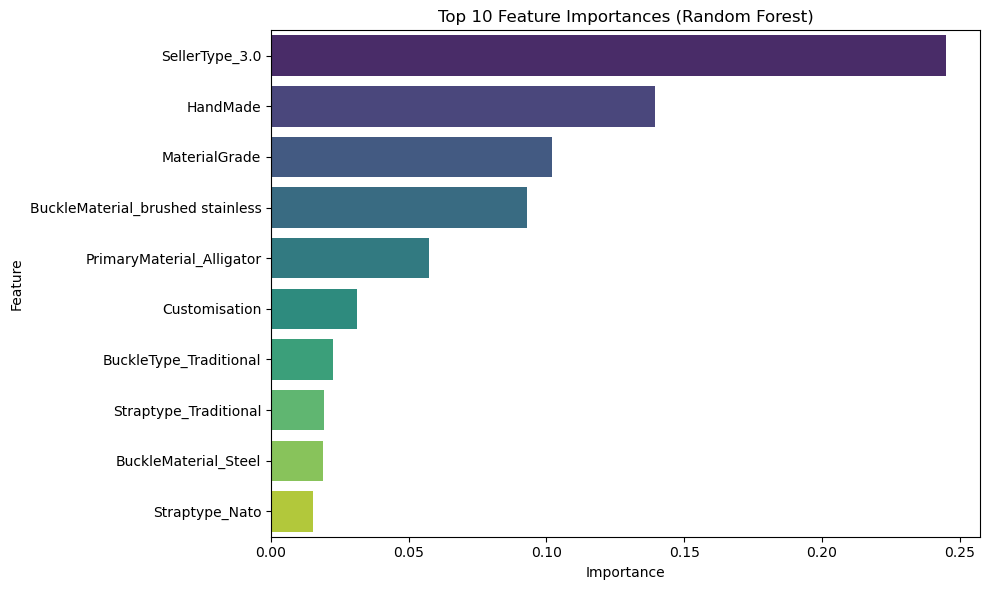

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. Load the dataset ---
df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\Dissertation\Custom Watchstraps main.csv")

# --- 3. Drop irrelevant columns ---
df = df.drop(columns=["ProductName", "URL", "SellerName", "Country", "Compatibility", "Unnamed: 11"], errors="ignore")

# --- 4. Drop missing values in key features ---
required_cols = [
    "Price", "MaterialGrade", "HandMade", "PrimaryMaterial", "Straptype",
    "BuckleType", "BuckleMaterial", "Stitching Style"
]
df = df.dropna(subset=required_cols)

# --- 5. Rename columns with spaces to underscores for formula compatibility ---
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))

# --- 6. Convert to categorical ---
categorical_cols = ["PrimaryMaterial", "Straptype", "BuckleType", "BuckleMaterial",
                    "Stitching_Style", "SellerType"]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# --- 6. Log transform the target ---
df["LogPrice"] = np.log(df["Price"])


# 📘 OLS HEDONIC REGRESSION

formula = """
LogPrice ~ C(HandMade) + C(MaterialGrade) + C(PrimaryMaterial) +
           C(Straptype) + C(BuckleType) + C(BuckleMaterial) +
           C(Stitching_Style) + C(SellerType)
"""
# --- 8. Create design matrices ---
y_ols, X_ols = patsy.dmatrices(formula, data=df, return_type='dataframe')

# --- 9. Fit OLS model ---
ols_model = sm.OLS(y_ols, X_ols).fit()

# --- 10. Print summary ---
print("\n===== OLS Hedonic Model =====")
print(ols_model.summary())

# --- 11. Convert to % effect interpretation ---
coef_df = ols_model.params.reset_index()
coef_df.columns = ["Variable", "Log Coef"]
coef_df["% Effect"] = (np.exp(coef_df["Log Coef"]) - 1) * 100
coef_df = coef_df.sort_values(by="% Effect", ascending=False)

print("\nTop Hedonic Effects (% Premium/Discount):")
print(coef_df.head(10))

summary_df = ols_model.summary2().tables[1] 
summary_df.to_csv(r"C:\Users\User\OneDrive\Desktop\Dissertation\OLS_Full_Results.csv")
# 🌲 RANDOM FOREST MODEL


# --- 12. Prepare features and target ---
X_rf = df.drop(columns=["Price", "LogPrice"])
y_rf = df["LogPrice"]

# --- 13. Preprocessing pipeline ---
cat_features = X_rf.select_dtypes(include=["category"]).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_features)
    ],
    remainder="passthrough"
)

# --- 14. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# --- 15. Build RF pipeline ---
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_estimators=200))
])

rf_pipeline.fit(X_train, y_train)

# --- 16. Evaluate RF model ---
y_pred_rf = rf_pipeline.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n===== Random Forest Model =====")
print(f"R² Score: {r2_rf:.4f}")
print(f"RMSE (Log-Price): {rmse_rf:.4f}")

# --- 17. Feature importances ---
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_features)
numeric_features = X_rf.select_dtypes(exclude=["category"]).columns.tolist()
all_features = list(ohe_features) + numeric_features

importances = rf_pipeline.named_steps["regressor"].feature_importances_
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- 18. Plot top features ---
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()